# How did total number of daily instructor events change over the semester

In [1]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
import matplotlib.ticker as ticker
import sys
sys.path.insert(0, '/home/jenny/remote_learning_code_Spring_2017-2020')
from utils import parse_args

sys.argv = ['-f']
args = parse_args()

term_20 = args.semester_2020_Spring
start_date_20 = args.start_date_2020_Spring
remote_date_20 = args.remote_date_2020_Spring
end_date_20 = args.end_date_2020_Spring

term_19 = args.semester_2019_Spring
start_date_19 = args.start_date_2019_Spring
cutoff_date_19 = args.cutoff_date_2019_Spring
end_date_19 = args.end_date_2019_Spring

term_18 = args.semester_2018_Spring
start_date_18 = args.start_date_2018_Spring
cutoff_date_18 = args.cutoff_date_2018_Spring
end_date_18 = args.end_date_2018_Spring

term_17 = args.semester_2017_Spring
start_date_17 = args.start_date_2017_Spring
cutoff_date_17 = args.cutoff_date_2017_Spring
end_date_17 = args.end_date_2017_Spring

In [2]:
def process(term, start_date, end_date, assignments_file, assignments_overrides_file, assign_group_file, submission_file, comments_file, discussion_topic_file, discussion_entry_file):
    # load assignments
    assignments = pd.read_csv(assignments_file, sep='\t', header=0)
    #if term != term_20 or (term == term_20 and assignments_file == args.assignments):
    #    assignments = assignments.loc[assignments['term_name']==term]
    assignments = assignments.loc[(assignments['asn_created_at']>=start_date)&(assignments['asn_created_at']<=end_date), ['assignment_id', 'asn_created_at', 'asn_unlock_at', 'asn_due_at']]  # no duplicate exists
    assi_time = assignments['asn_created_at']

    # load assignments overrides
    assignments_overrides = pd.read_csv(assignments_overrides_file, sep='\t', header=0)
    assignments_overrides = assignments_overrides.loc[assignments_overrides['term_name']==term]
    assignments_overrides = assignments_overrides.loc[(assignments_overrides['created_at']>=start_date)&(assignments_overrides['created_at']<=end_date), ['assignment_id', 'created_at']]
    over_time = assignments_overrides['created_at']


    # load assign groups
    assign_groups = pd.read_csv(assign_group_file, sep='\t', header=0)
    assign_groups = assign_groups.loc[(assign_groups['group_created_at']>=start_date)&(assign_groups['group_created_at']<=end_date)]
    assi_group_time = assign_groups['group_created_at']

    # load grading
    submission = pd.read_csv(submission_file, sep='\t', header=0)
    submission = submission.loc[submission['term_name']==term]
    submission = submission.loc[(submission['graded_at'].notnull())&(submission['graded_at']>=start_date)&(submission['graded_at']<=end_date), ['user_id', 'assignment_id', 'graded_at']] # no duplicate exists
    grade_time = submission['graded_at']

    # loading submission comments
    comments = pd.read_csv(comments_file, sep='\t', header=0)
    comments = comments.loc[comments['term_name']==term]
    f = open('../user_id_groups.pkl', 'rb')
    user = pickle.load(f)
    teacher = user['teacher']
    ta = user['ta']
    users = teacher + ta
    comments = comments.loc[(comments['author_id'].isin(users))&(comments['message_size_bytes']>0)&(comments['created_at']>=start_date)&(comments['created_at']<=end_date), ['author_id', 'submission_id', 'assignment_id', 'created_at', 'message_size_bytes']]
    comments_time = comments['created_at']

    # loading announcements
    announce = pd.read_csv(discussion_topic_file, sep='\t', header=0)  #discussion topics
    announce = announce.loc[announce['term_name']==term]
    announce = announce.loc[(announce['workflow_state']=='active')&(announce['user_id'].isin(users))]
    announce = announce.loc[(announce['created_at']>=start_date)&(announce['created_at']<=end_date)]
    announce_time = announce['created_at']

    #comments['created_at'] = pd.to_datetime(comments['created_at'], format='%Y-%m-%d %H:%M:%S.%f')
    discussion_entry = pd.read_csv(discussion_entry_file, sep='\t', header=0)
    discussion_entry = discussion_entry.loc[(discussion_entry['workflow_state']=='active')&(discussion_entry['created_at']>=start_date)&(discussion_entry['created_at']<=end_date)]
    entry_time = discussion_entry['created_at']

    time = pd.concat((assi_time, over_time, assi_group_time, grade_time, comments_time, announce_time, entry_time), axis=0)
    return time
    #unlock = assignments.loc[(assignments['asn_unlock_at']>'2020-01-14')&(assignments['asn_unlock_at']<'2020-05-25'), ['assignment_id', 'asn_unlock_at']].drop_duplicates()
    #unlock['asn_unlock_at'] = unlock['asn_unlock_at'].apply(lambda x: x.date())
    #unlock_group = unlock.groupby('asn_unlock_at').size()

In [3]:
time_20 = process(term_20, start_date_20, end_date_20, args.assignments, args.assignments_overrides, args.assignment_groups, args.submissions, args.submission_comments, args.discussion_topics, args.discussion_entry)
time_19 = process(term_19, start_date_19, end_date_19, args.assignments, args.assignments_overrides, args.assignment_groups, args.submissions, args.submission_comments, args.discussion_topics, args.discussion_entry)
time_18 = process(term_18, start_date_18, end_date_18, args.assignments, args.assignments_overrides, args.assignment_groups, args.submissions, args.submission_comments, args.discussion_topics, args.discussion_entry)
time_17 = process(term_17, start_date_17, end_date_17, args.assignments, args.assignments_overrides, args.assignment_groups, args.submissions, args.submission_comments, args.discussion_topics, args.discussion_entry)

In [4]:
time_20 = pd.to_datetime(time_20, format='%Y-%m-%d %H:%M:%S.%f').apply(lambda x: x.date())
time_19 = pd.to_datetime(time_19, format='%Y-%m-%d %H:%M:%S.%f').apply(lambda x: x.date())
time_18 = pd.to_datetime(time_18, format='%Y-%m-%d %H:%M:%S.%f').apply(lambda x: x.date())
time_17 = pd.to_datetime(time_17, format='%Y-%m-%d %H:%M:%S.%f').apply(lambda x: x.date())
time_20 = time_20.to_frame(name='date').groupby('date').size()
time_19 = time_19.to_frame(name='date').groupby('date').size()
time_18 = time_18.to_frame(name='date').groupby('date').size()
time_17 = time_17.to_frame(name='date').groupby('date').size()

In [5]:
time_20 = time_20.reset_index()
time_19 = time_19.reset_index()
time_18 = time_18.reset_index()
time_17 = time_17.reset_index()
time_20.set_index('date', inplace=True)
time_19['date'] = time_19['date'].apply(lambda x: x.replace(year=2020))
time_19.set_index('date', inplace=True)
time_18['date'] = time_18['date'].apply(lambda x: x.replace(year=2020))
time_18.set_index('date', inplace=True)
time_17['date'] = time_17['date'].apply(lambda x: x.replace(year=2020))
time_17.set_index('date', inplace=True)

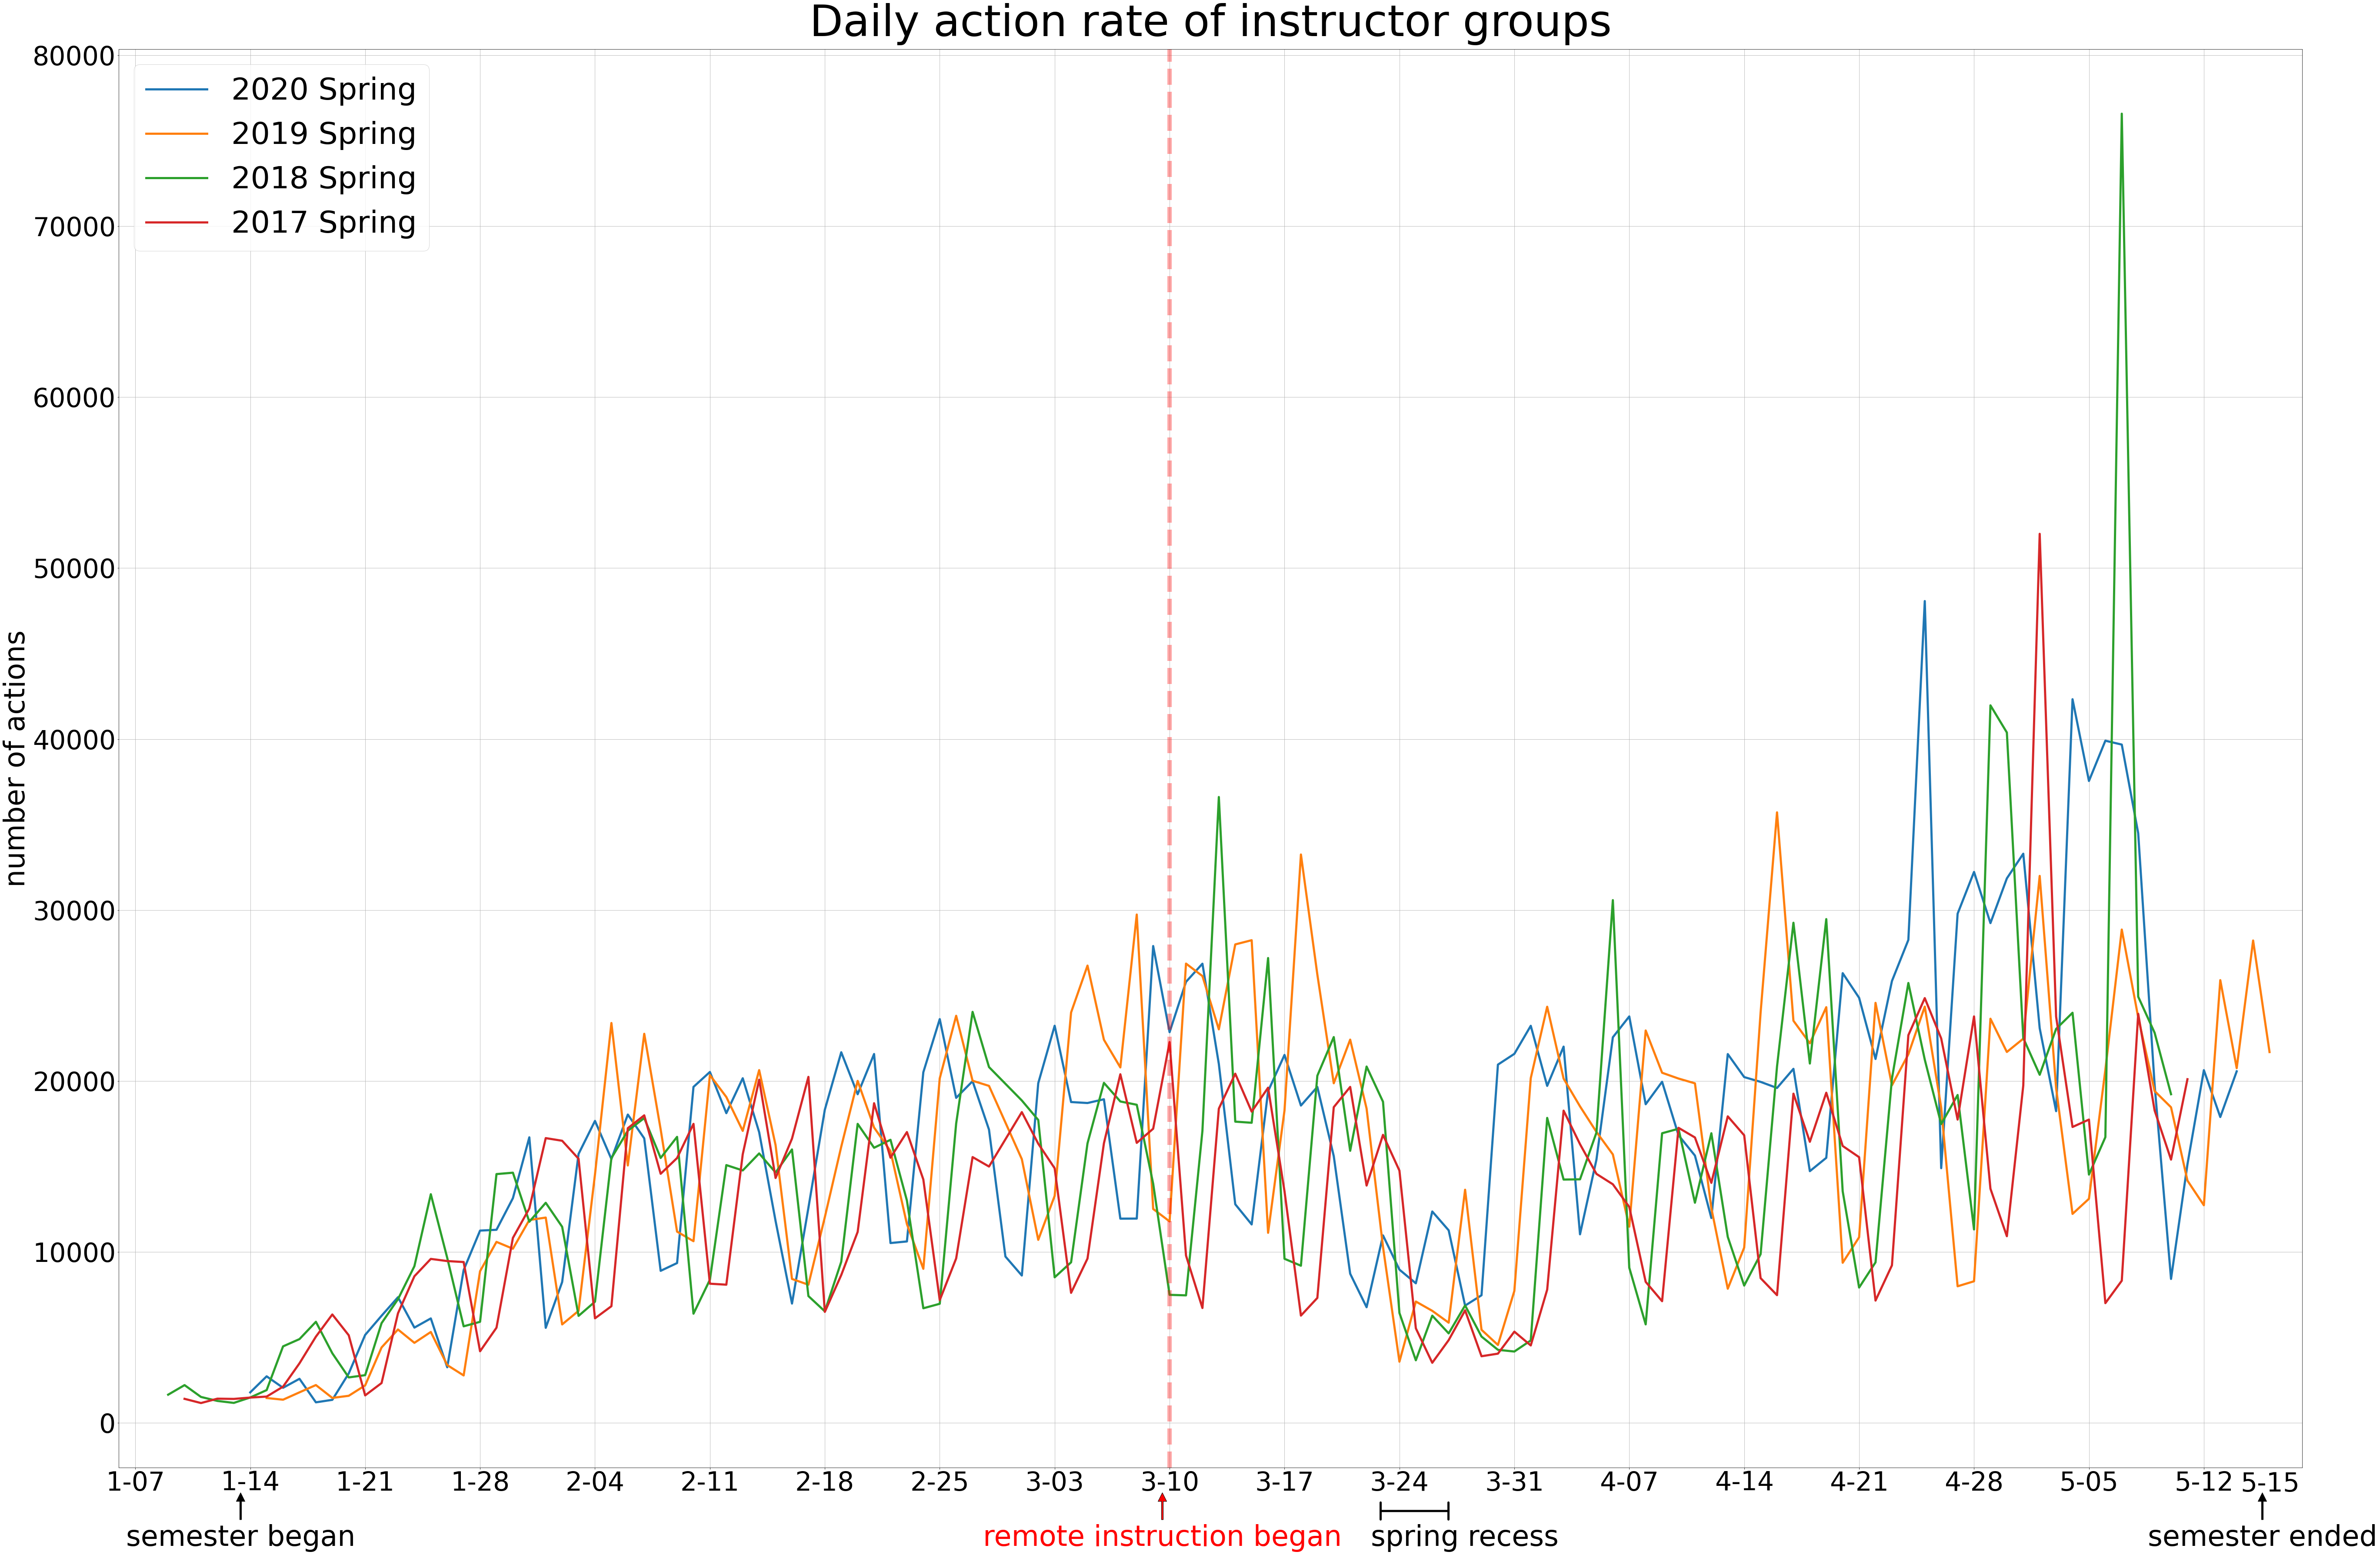

In [7]:


# set x-axis ticks
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(time_20, linewidth=5.0, label='2020 Spring')
plt.plot(time_19, linewidth=5.0, label='2019 Spring')
plt.plot(time_18, linewidth=5.0, label='2018 Spring')
plt.plot(time_17, linewidth=5.0, label='2017 Spring')

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Daily action rate of instructor groups', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('number of actions', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
plt.legend(prop={'size': 70})
plt.show()



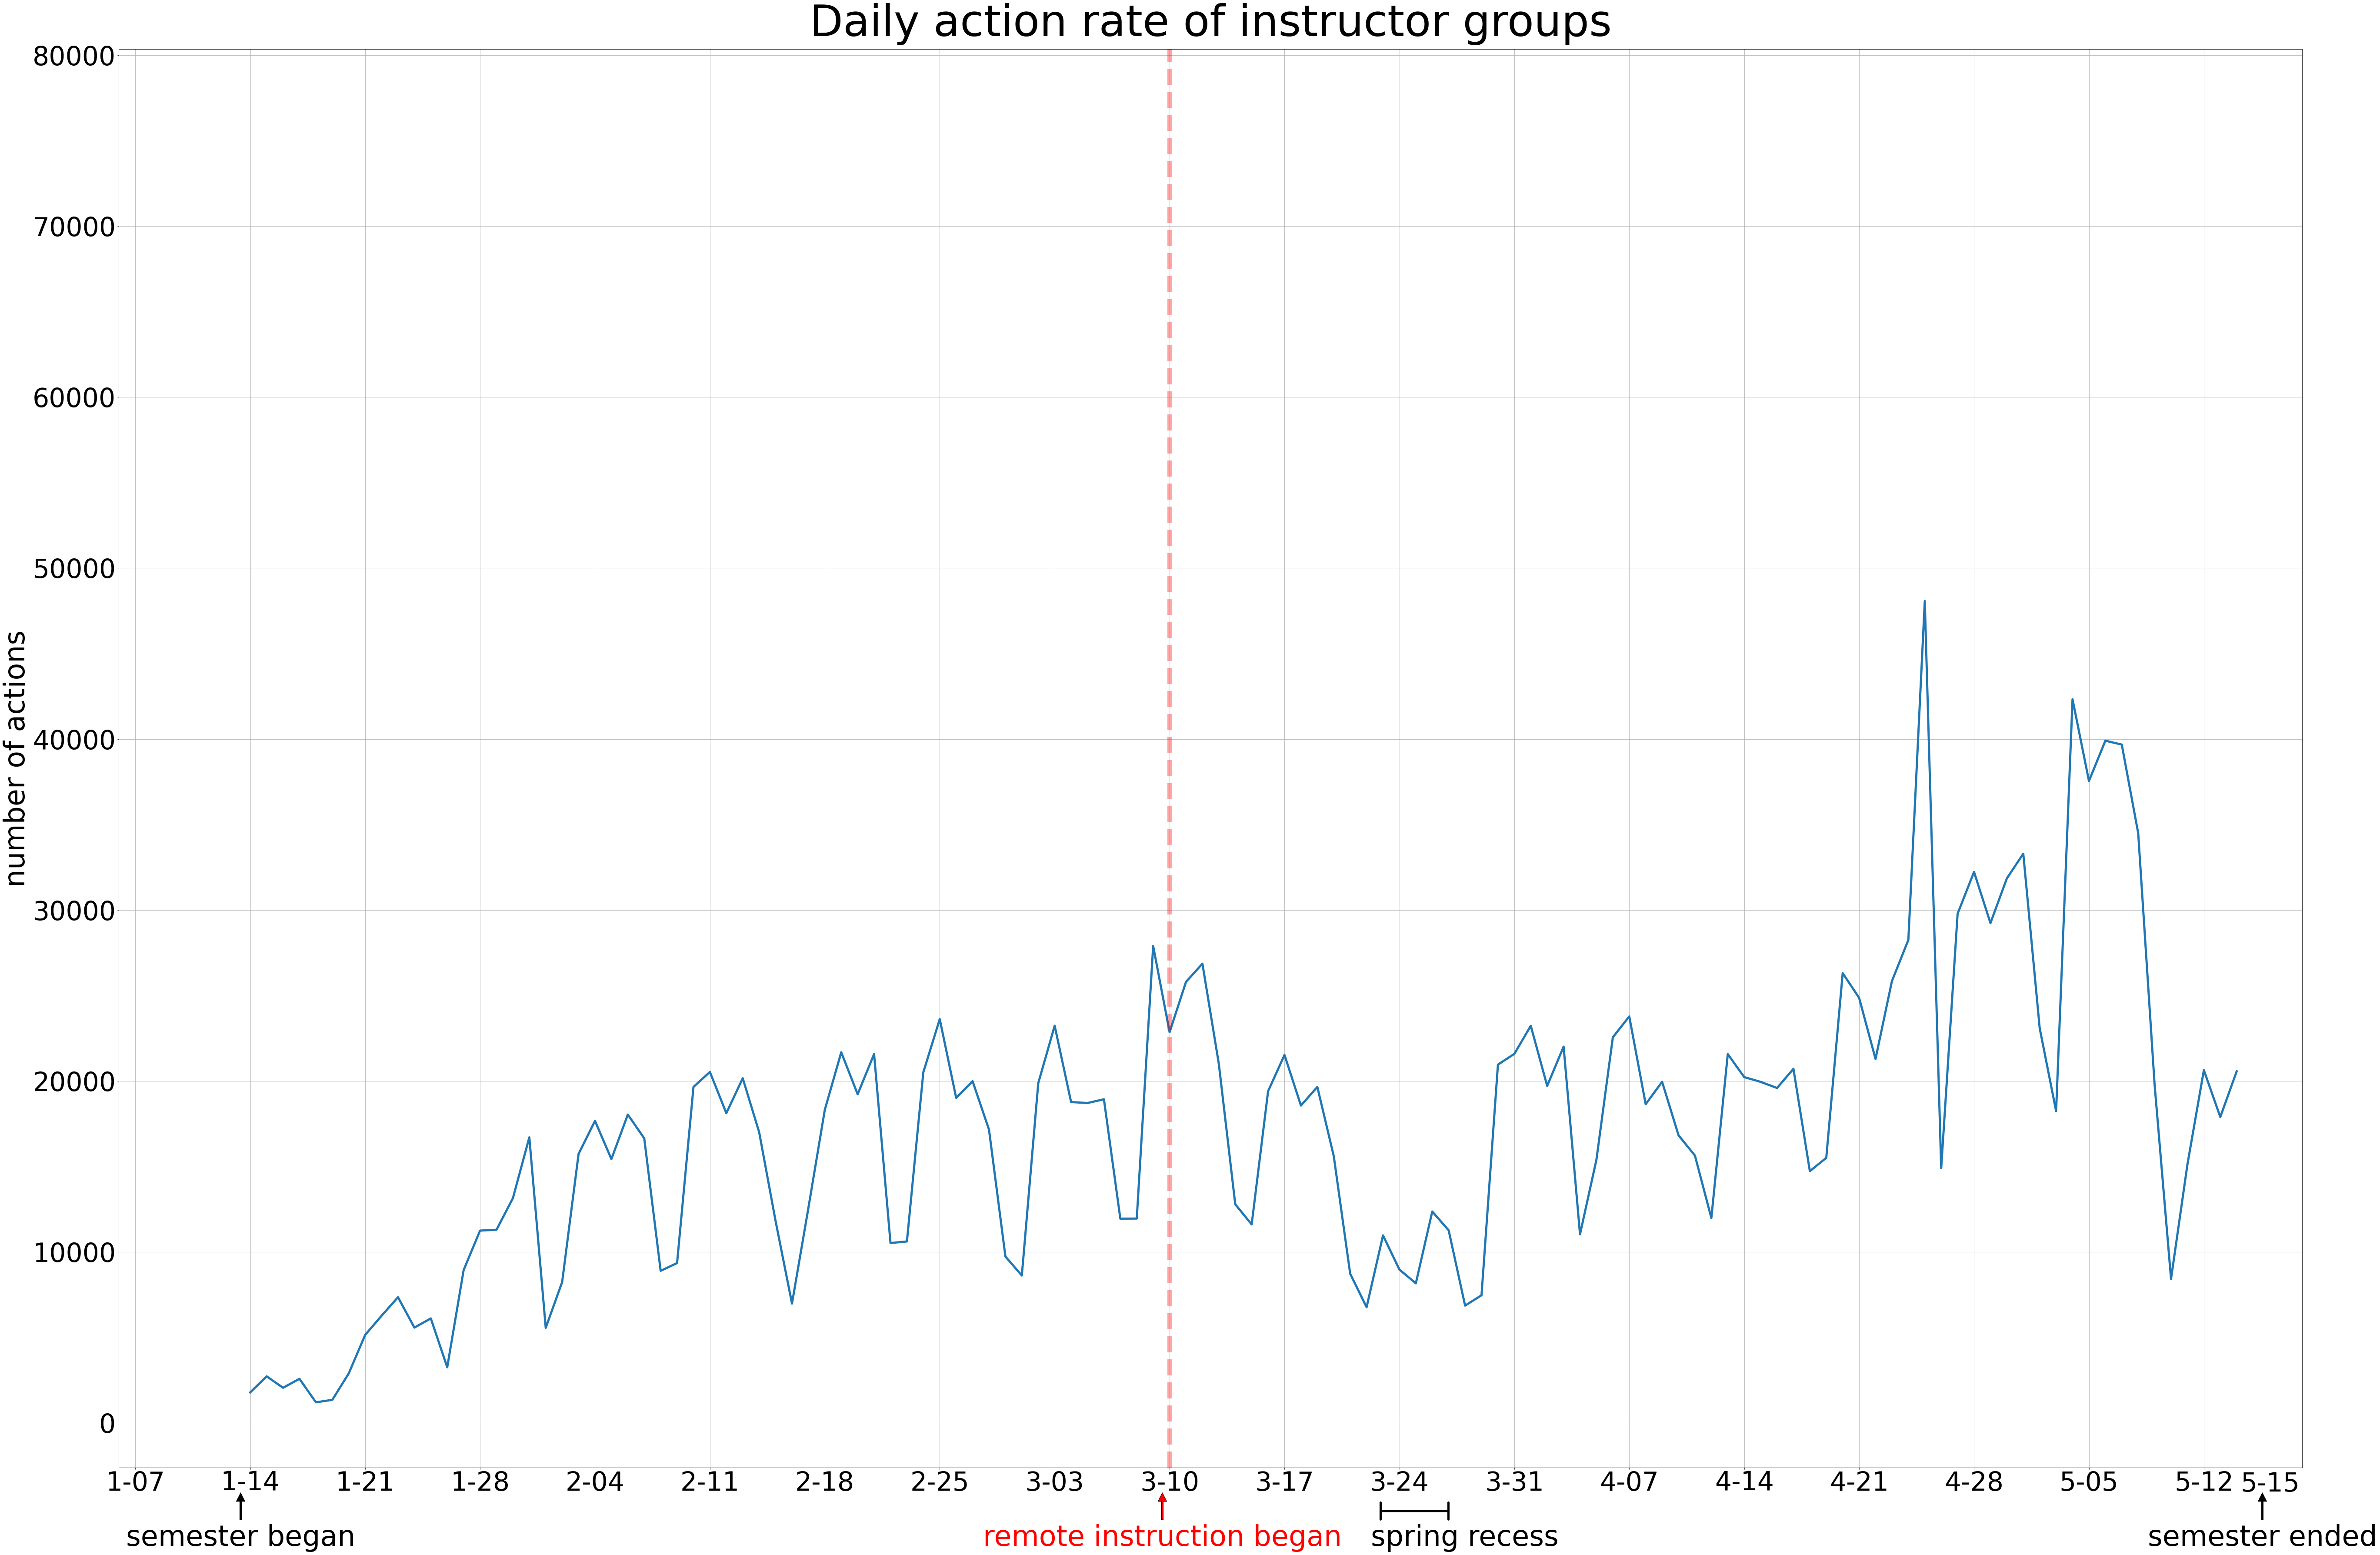

In [8]:


# set x-axis ticks
fig,ax = plt.subplots()
fig.patch.set_facecolor('white')
myFmt = mdates.DateFormatter('%-m-%d')
ax.xaxis.set_major_formatter(myFmt)
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.set_xlim([datetime.date(2020, 1, 6), datetime.date(2020, 5, 18)])

plt.plot(time_20, linewidth=5.0, label='2020 Spring')
plt.plot(time_19, linewidth=5.0, label='2019 Spring', alpha=0)
plt.plot(time_18, linewidth=5.0, label='2018 Spring', alpha=0)
plt.plot(time_17, linewidth=5.0, label='2017 Spring', alpha=0)

plt.xticks(fontsize=60)
plt.yticks(fontsize=60)
plt.grid(True)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 90
fig_size[1] = 60
plt.rcParams["figure.figsize"] = fig_size
plt.title('Daily action rate of instructor groups', fontsize=100, pad=30)
#plt.xlabel('date', fontsize=65, labelpad=120)
plt.ylabel('number of actions', fontsize=65)

# annotation on x-axis

ax.annotate('semester began', fontsize=65, xy=(280, -50), xytext=(280, -180), xycoords='axes points', ha='center',
           arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('remote instruction began', color='red', fontsize=65, xy=(2400, -50), xytext=(2400, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='red', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('semester ended', fontsize=65, xy=(4930, -50), xytext=(4930, -180), xycoords='axes points', ha='center', arrowprops=dict(facecolor='black', shrink=0.1, headlength=20, headwidth=20))
ax.annotate('5-15', fontsize=60, xy=(4880, -55), xycoords='axes points')

ax.annotate('', fontsize=65, xy=(2900, -100), xytext=(3060, -100),
            xycoords='axes points',
            arrowprops=dict(arrowstyle='|-|,widthA=0.3,widthB=0.3', linewidth=5))
ax.annotate('spring recess', fontsize=65, xy=(2880, -180), xycoords='axes points')
plt.axvline(x=datetime.date(2020, 3, 10), color = 'r', linewidth=10, alpha=0.35, linestyle='--')
#plt.legend(prop={'size': 70})
plt.show()

